In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped, PURankingLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## Load Data

In [18]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")

In [21]:
features_path = os.path.join(DATA_DIR, "features.txt")
features = pd.read_csv(features_path, sep='\s+', header=None, names=['index', 'feature_name'])['feature_name'].tolist()

In [278]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    sep='\s+',
    header=None,
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    sep='\s+',
    header=None,
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

In [279]:
pd.set_option('display.max_columns', None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.992042,0.994429,0.991756,0.989352,-0.994453,-0.999938,-0.999954,-0.999923,-0.992300,-0.996939,-0.992243,-0.589851,-0.688459,-0.572107,0.292376,-0.361998,0.405543,-0.039007,0.989284,-0.414560,0.391603,0.282251,0.927270,-0

In [280]:
activity_labels_df = pd.read_csv("data/UCI HAR Dataset/activity_labels.txt", sep='\s+', header=None, names=["id", "label"])
print(activity_labels_df)
labels = activity_labels_df["label"].to_list()

   id               label
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [281]:
y_train_np = y_train.to_numpy() - 1
y_test_np = y_test.to_numpy() - 1

In [282]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


In [283]:
X_tr_tensor   = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_tr_tensor   = torch.tensor(y_train.values, dtype=torch.long) - 1
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) - 1


In [284]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [285]:
batch_size = 64

tr_dataset   = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # train 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

In [109]:
def change_labels(y_train, y_test, fr, to):
    return np.where(y_train == fr, to, 1), np.where(y_test == fr, to, 1)

## PU-learnining 

### Transform Data to PU Problem

In [286]:
positive_class = 2
unlabeled_label = 0

y_train = np.where(y_train_np == positive_class, 1, unlabeled_label)
y_test = np.where(y_test_np == positive_class, 1, unlabeled_label)

In [287]:
positive_class = 2
unlabeled_label = 0

y_train_pu = np.where(y_train_np == positive_class, 1, unlabeled_label)
y_test_pu = np.where(y_test_np == positive_class, 1, unlabeled_label)
print(f"Positives before reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives before reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


pos_idx_tr = np.where(y_train_pu == 1)[0]
pos_idx_tst = np.where(y_test_pu == 1)[0]
np.random.seed(0)
unmark_pos_tr = np.random.choice(pos_idx_tr, size=len(pos_idx_tr)//2, replace=False)
y_train_pu[unmark_pos_tr] = unlabeled_label
unmark_pos_tst = np.random.choice(pos_idx_tst, size=len(pos_idx_tst)//2, replace=False)
y_test_pu[unmark_pos_tst] = unlabeled_label
print(f"Positives after reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives after reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


Positives before reduction, train: 986
Positives before reduction, test: 420
Positives after reduction, train: 493
Positives after reduction, test: 210


In [288]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [289]:
batch_size = 64

In [290]:
y_tr_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

tr_dataset_pu   = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader = DataLoader(tr_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


In [291]:
# positive_prior = np.where(y_train_np == positive_class, 1, 0).mean()
# positive_prior

positive_prior = torch.tensor(
    np.where(y_train_np == positive_class, 1, 0).mean(),
    dtype=torch.float32
)
# positive_prior = torch.tensor((y_train_pu).mean(),
#                               dtype=torch.float32)

positive_prior = torch.tensor(
    np.where(y_train_pu == 1, 1, 0).mean(),
    dtype=torch.float32
)
positive_prior

tensor(0.0671)

## CNN

In [292]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_tr_tensor_pu.unique())-1
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 1


In [86]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)


## CrossEntropy Loss

In [92]:
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:00<00:00, 154.17it/s]


Epoch [1/15], tr_loss: 0.30529 tr_acc: 0.93294 test_loss: 0.29578, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 228.31it/s]


Epoch [2/15], tr_loss: 0.29184 tr_acc: 0.93294 test_loss: 0.29000, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 232.14it/s]


Epoch [3/15], tr_loss: 0.28601 tr_acc: 0.93294 test_loss: 0.28508, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 246.19it/s]


Epoch [4/15], tr_loss: 0.27875 tr_acc: 0.93294 test_loss: 0.28065, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 255.94it/s]


Epoch [5/15], tr_loss: 0.27342 tr_acc: 0.93294 test_loss: 0.27595, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 252.49it/s]


Epoch [6/15], tr_loss: 0.26923 tr_acc: 0.93294 test_loss: 0.27318, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 254.10it/s]


Epoch [7/15], tr_loss: 0.26544 tr_acc: 0.93294 test_loss: 0.26963, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 253.26it/s]


Epoch [8/15], tr_loss: 0.26201 tr_acc: 0.93349 test_loss: 0.26754, test_acc: 0.92942


100%|██████████| 115/115 [00:00<00:00, 243.97it/s]


Epoch [9/15], tr_loss: 0.25748 tr_acc: 0.93308 test_loss: 0.26403, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 250.78it/s]


Epoch [10/15], tr_loss: 0.25502 tr_acc: 0.93267 test_loss: 0.26201, test_acc: 0.92467


100%|██████████| 115/115 [00:00<00:00, 256.80it/s]


Epoch [11/15], tr_loss: 0.25316 tr_acc: 0.93050 test_loss: 0.25936, test_acc: 0.92501


100%|██████████| 115/115 [00:00<00:00, 252.85it/s]


Epoch [12/15], tr_loss: 0.24922 tr_acc: 0.93199 test_loss: 0.25543, test_acc: 0.92671


100%|██████████| 115/115 [00:00<00:00, 231.30it/s]


Epoch [13/15], tr_loss: 0.24556 tr_acc: 0.93281 test_loss: 0.25356, test_acc: 0.92772


100%|██████████| 115/115 [00:00<00:00, 229.60it/s]


Epoch [14/15], tr_loss: 0.24262 tr_acc: 0.93498 test_loss: 0.25002, test_acc: 0.92806


100%|██████████| 115/115 [00:00<00:00, 234.10it/s]


Epoch [15/15], tr_loss: 0.24201 tr_acc: 0.93240 test_loss: 0.24990, test_acc: 0.92195


In [93]:
model.eval()
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9211    0.9589      6859
           1     0.4768    1.0000    0.6457       493

    accuracy                         0.9264      7352
   macro avg     0.7384    0.9606    0.8023      7352
weighted avg     0.9649    0.9264    0.9379      7352

[[6318  541]
 [   0  493]]


In [94]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9925    0.9962      6366
           1     0.9536    1.0000    0.9762       986

    accuracy                         0.9935      7352
   macro avg     0.9768    0.9962    0.9862      7352
weighted avg     0.9938    0.9935    0.9935      7352

[[6318   48]
 [   0  986]]


In [96]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9968    0.9189    0.9563      2737
           1     0.4764    0.9619    0.6372       210

    accuracy                         0.9220      2947
   macro avg     0.7366    0.9404    0.7967      2947
weighted avg     0.9597    0.9220    0.9335      2947

[[2515  222]
 [   8  202]]


In [97]:
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9913    0.9897    0.9905      2527
           1     0.9387    0.9476    0.9431       420

    accuracy                         0.9837      2947
   macro avg     0.9650    0.9687    0.9668      2947
weighted avg     0.9838    0.9837    0.9837      2947

[[2501   26]
 [  22  398]]


In [98]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 493
In percentage: 1.0000
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 196
In percentage: 0.9333


In [100]:
torch.save(model, "models/har_cnn_crossentropy.pth")

## PU Loss

In [104]:
y_train_pu_tensor = torch.tensor(np.where(y_train_pu == 1, 1, -1), dtype=torch.long)
y_test_pu_tensor = torch.tensor(np.where(y_test_pu == 1, 1, -1), dtype=torch.long)
batch_size = 64
print(X_tr_tensor.shape)
train_dataset = TensorDataset(X_tr_tensor, y_train_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [ ]:
y_train_pu, y_test_pu = change_labels(y_train_pu, y_test_pu, 0, -1)
y_train, y_test = change_labels(y_train, y_test, 0, -1)

In [ ]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior)

In [ ]:
lr = 0.0005
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1)
model.load_state_dict(torch.load("models/har_cnn_pu.pth"))
model = model.to(device)

/tmp/ipykernel_504/1688355383.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/har_cnn_pu.pth"))


In [234]:
model = train(model, criterion, train_loader, test_loader, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 104.93it/s]


Epoch [1/15], tr_loss: 0.13504 tr_acc: 0.92424 test_loss: 0.09210, test_acc: 0.92874


100%|██████████| 115/115 [00:00<00:00, 132.63it/s]


Epoch [2/15], tr_loss: 0.08872 tr_acc: 0.93172 test_loss: 0.08191, test_acc: 0.93146


100%|██████████| 115/115 [00:00<00:00, 139.47it/s]


Epoch [3/15], tr_loss: 0.07770 tr_acc: 0.93063 test_loss: 0.07921, test_acc: 0.93010


100%|██████████| 115/115 [00:00<00:00, 144.82it/s]


Epoch [4/15], tr_loss: 0.07385 tr_acc: 0.93131 test_loss: 0.07510, test_acc: 0.93485


100%|██████████| 115/115 [00:00<00:00, 138.14it/s]


Epoch [5/15], tr_loss: 0.07214 tr_acc: 0.93267 test_loss: 0.07008, test_acc: 0.93349


100%|██████████| 115/115 [00:00<00:00, 131.59it/s]


Epoch [6/15], tr_loss: 0.07112 tr_acc: 0.93471 test_loss: 0.06889, test_acc: 0.93247


100%|██████████| 115/115 [00:00<00:00, 135.60it/s]


Epoch [7/15], tr_loss: 0.06792 tr_acc: 0.93322 test_loss: 0.06739, test_acc: 0.93146


100%|██████████| 115/115 [00:00<00:00, 142.43it/s]


Epoch [8/15], tr_loss: 0.06507 tr_acc: 0.93607 test_loss: 0.06721, test_acc: 0.93078


100%|██████████| 115/115 [00:00<00:00, 140.28it/s]


Epoch [9/15], tr_loss: 0.05934 tr_acc: 0.93730 test_loss: 0.06565, test_acc: 0.93112


100%|██████████| 115/115 [00:00<00:00, 177.33it/s]


Epoch [10/15], tr_loss: 0.05720 tr_acc: 0.93784 test_loss: 0.06593, test_acc: 0.93180


100%|██████████| 115/115 [00:00<00:00, 188.50it/s]


Epoch [11/15], tr_loss: 0.05502 tr_acc: 0.94002 test_loss: 0.06563, test_acc: 0.93078


100%|██████████| 115/115 [00:00<00:00, 188.06it/s]


Epoch [12/15], tr_loss: 0.05346 tr_acc: 0.93702 test_loss: 0.06461, test_acc: 0.92976


100%|██████████| 115/115 [00:00<00:00, 189.76it/s]


Epoch [13/15], tr_loss: 0.05358 tr_acc: 0.93866 test_loss: 0.06659, test_acc: 0.93044


100%|██████████| 115/115 [00:00<00:00, 172.74it/s]


Epoch [14/15], tr_loss: 0.05227 tr_acc: 0.94328 test_loss: 0.06433, test_acc: 0.92942


100%|██████████| 115/115 [00:00<00:00, 183.96it/s]


Epoch [15/15], tr_loss: 0.05167 tr_acc: 0.94029 test_loss: 0.06532, test_acc: 0.92806


In [241]:
model.eval()
out_train = model(X_tr_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

          -1     0.9938    0.9408    0.9666      6859
           1     0.5274    0.9189    0.6701       493

    accuracy                         0.9393      7352
   macro avg     0.7606    0.9298    0.8184      7352
weighted avg     0.9626    0.9393    0.9467      7352

[[6453  406]
 [  40  453]]


In [242]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

          -1     0.9804    1.0000    0.9901      6366
           1     1.0000    0.8712    0.9312       986

    accuracy                         0.9827      7352
   macro avg     0.9902    0.9356    0.9606      7352
weighted avg     0.9831    0.9827    0.9822      7352

[[6366    0]
 [ 127  859]]


In [243]:
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9766    0.9456    0.9608      2737
           1     0.4983    0.7048    0.5838       210

    accuracy                         0.9284      2947
   macro avg     0.7375    0.8252    0.7723      2947
weighted avg     0.9425    0.9284    0.9340      2947

[[2588  149]
 [  62  148]]


In [244]:
print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9532    0.9996    0.9759      2527
           1     0.9966    0.7048    0.8257       420

    accuracy                         0.9576      2947
   macro avg     0.9749    0.8522    0.9008      2947
weighted avg     0.9594    0.9576    0.9544      2947

[[2526    1]
 [ 124  296]]


In [245]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 406
In percentage: 0.8235
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 148
In percentage: 0.7048


In [216]:
torch.save(model.state_dict(), "models/har_cnn_pu.pth")

## Mamba

In [299]:
from baseline import MambaClassifier, train, PULoss

#criterion = PULoss(positive_prior=0.15, nnPU=True)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
model_mamba = MambaClassifier(in_channel, hidden_dim=64, num_classes=2, num_layers=1, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (blocks): Sequential(
    (0): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [300]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.001, 15, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:03<00:00, 35.72it/s]


Epoch [1/15], tr_loss: 0.41075 tr_acc: 0.79625 test_loss: 0.34040, test_acc: 0.80896


100%|██████████| 115/115 [00:02<00:00, 38.80it/s]


Epoch [2/15], tr_loss: 0.34955 tr_acc: 0.76959 test_loss: 0.34115, test_acc: 0.82457


100%|██████████| 115/115 [00:02<00:00, 38.82it/s]


Epoch [3/15], tr_loss: 0.34577 tr_acc: 0.76401 test_loss: 0.34406, test_acc: 0.83373


100%|██████████| 115/115 [00:02<00:00, 38.74it/s]


Epoch [4/15], tr_loss: 0.34607 tr_acc: 0.76224 test_loss: 0.34139, test_acc: 0.82592


100%|██████████| 115/115 [00:02<00:00, 38.34it/s]


Epoch [5/15], tr_loss: 0.34492 tr_acc: 0.76238 test_loss: 0.33818, test_acc: 0.81880


100%|██████████| 115/115 [00:02<00:00, 38.44it/s]


Epoch [6/15], tr_loss: 0.34292 tr_acc: 0.76238 test_loss: 0.33593, test_acc: 0.80964


100%|██████████| 115/115 [00:02<00:00, 38.66it/s]


Epoch [7/15], tr_loss: 0.34043 tr_acc: 0.76387 test_loss: 0.33479, test_acc: 0.80251


100%|██████████| 115/115 [00:02<00:00, 38.47it/s]


Epoch [8/15], tr_loss: 0.33827 tr_acc: 0.76387 test_loss: 0.33389, test_acc: 0.79708


100%|██████████| 115/115 [00:02<00:00, 38.55it/s]


Epoch [9/15], tr_loss: 0.33635 tr_acc: 0.76428 test_loss: 0.33320, test_acc: 0.79233


100%|██████████| 115/115 [00:02<00:00, 38.57it/s]


Epoch [10/15], tr_loss: 0.33462 tr_acc: 0.76510 test_loss: 0.33246, test_acc: 0.79063


100%|██████████| 115/115 [00:02<00:00, 38.49it/s]


Epoch [11/15], tr_loss: 0.33310 tr_acc: 0.76659 test_loss: 0.33179, test_acc: 0.78928


100%|██████████| 115/115 [00:03<00:00, 38.04it/s]


Epoch [12/15], tr_loss: 0.33172 tr_acc: 0.76687 test_loss: 0.33110, test_acc: 0.78724


100%|██████████| 115/115 [00:03<00:00, 38.09it/s]


Epoch [13/15], tr_loss: 0.33041 tr_acc: 0.76877 test_loss: 0.33037, test_acc: 0.78690


100%|██████████| 115/115 [00:03<00:00, 37.81it/s]


Epoch [14/15], tr_loss: 0.32916 tr_acc: 0.76877 test_loss: 0.32974, test_acc: 0.78453


100%|██████████| 115/115 [00:03<00:00, 38.30it/s]


Epoch [15/15], tr_loss: 0.32766 tr_acc: 0.76931 test_loss: 0.32917, test_acc: 0.78317


In [301]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [302]:
X_tr_tensor_inf = X_tr_tensor.permute(0, 2, 1) 

In [303]:
train_dataset = TensorDataset(X_tr_tensor_inf, torch.from_numpy(y_train_pu))
train_loader = DataLoader(train_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_train.append(preds.cpu())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))


ValueError: Found input variables with inconsistent numbers of samples: [7352, 14704]

In [267]:
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.9293    0.9996    0.9632      2737
           1     0.6667    0.0095    0.0188       210

    accuracy                         0.9291      2947
   macro avg     0.7980    0.5046    0.4910      2947
weighted avg     0.9106    0.9291    0.8959      2947

[[2736    1]
 [ 208    2]]


In [268]:
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

preds_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        preds_test.append(preds.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))


              precision    recall  f1-score   support

          -1     0.8584    1.0000    0.9238      2527
           1     1.0000    0.0071    0.0142       420

    accuracy                         0.8585      2947
   macro avg     0.9292    0.5036    0.4690      2947
weighted avg     0.8785    0.8585    0.7941      2947

[[2527    0]
 [ 417    3]]


In [276]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 36
In percentage: 0.0730
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 1
In percentage: 0.0048


In [ ]:
torch.save(model_mamba.state_dict, "models/pu_mambe_test1.pth")

In [304]:
torch.save(model_mamba.state_dict, "models/har_mamba_crossentropy.pth")

## InceptionTime

In [308]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped

#criterion = PULossWrapped(prior=positive_prior, nnPU=True)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.525599,0.438596,0.410711,0.748897,00:09
1,0.322969,0.825932,0.487920,0.620631,00:08
2,0.246048,0.903509,0.555033,0.622328,00:09
3,0.211627,0.919956,1.268370,0.077706,00:09
4,0.181059,0.926672,0.293002,0.835087,00:09
5,0.168204,0.930236,1.371067,0.929080,00:09
6,0.148223,0.933799,0.491628,0.929080,00:09
7,0.140496,0.935307,0.232708,0.931795,00:09
8,0.132583,0.936541,0.277738,0.929759,00:09
9,0.128533,0.934759,0.242222,0.931116,00:09


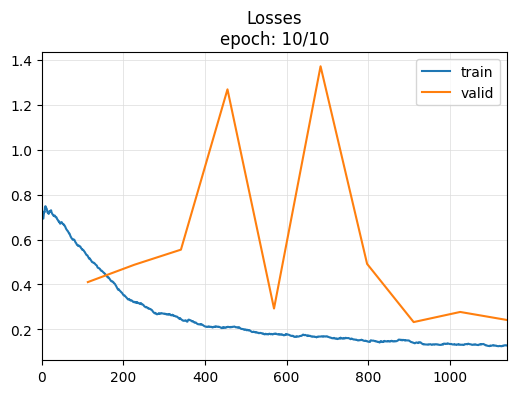

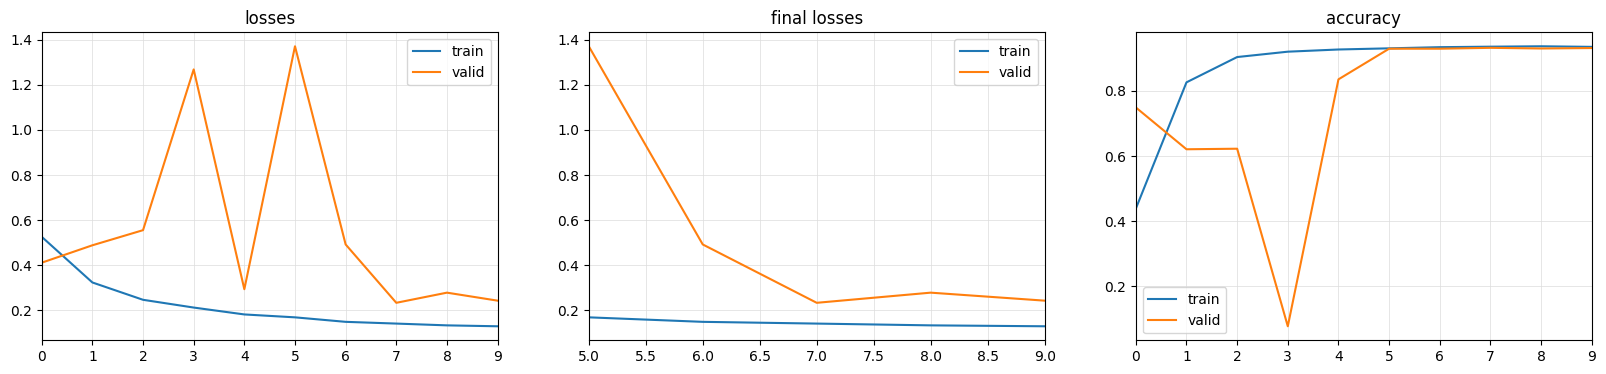

In [309]:
clf.fit_one_cycle(10, 1e-4)

In [310]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [311]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(target, preds_train, digits=4))
print(confusion_matrix(target, preds_train))

              precision    recall  f1-score   support

           0     1.0000    0.9305    0.9640      6859
           1     0.5082    1.0000    0.6740       493

    accuracy                         0.9351      7352
   macro avg     0.7541    0.9652    0.8190      7352
weighted avg     0.9670    0.9351    0.9445      7352

[[6382  477]
 [   0  493]]


In [312]:
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9972    0.9997    0.9984      6366
           1     0.9979    0.9817    0.9898       986

    accuracy                         0.9973      7352
   macro avg     0.9976    0.9907    0.9941      7352
weighted avg     0.9973    0.9973    0.9973      7352

[[6364    2]
 [  18  968]]


In [316]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(target, preds, digits=4))
print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9877    0.9375    0.9619      2737
           1     0.5100    0.8476    0.6369       210

    accuracy                         0.9311      2947
   macro avg     0.7489    0.8926    0.7994      2947
weighted avg     0.9536    0.9311    0.9388      2947

[[2566  171]
 [  32  178]]


In [314]:
print(classification_report(y_test, preds, digits=4))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0     0.9727    1.0000    0.9861      2527
           1     1.0000    0.8310    0.9077       420

    accuracy                         0.9759      2947
   macro avg     0.9863    0.9155    0.9469      2947
weighted avg     0.9766    0.9759    0.9750      2947

[[2527    0]
 [  71  349]]


In [317]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unmark_pos_tr] == y_train[unmark_pos_tr]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tr)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unmark_pos_tr)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unmark_pos_tst] == y_test[unmark_pos_tst]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unmark_pos_tst)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unmark_pos_tst)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 475
In percentage: 0.9635
Test
Total number of positive sampels:420
Total number of unmarked positive sampels: 210
Number of unmarked samples correctly predicted as positive: 171
In percentage: 0.8143


In [ ]:
from transformers import MambaConfig, MambaModel 
# config = MambaConfig(
#     d_model=128,         # Hidden size appropriate for your HAR data
#     n_layer=12,          # Number of sequence layers
#     vocab_size=None,     # Not relevant for time series, you can omit or set extraneously
#     # Set other config options as needed
# )
# model = MambaModel(config)

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434